In [1]:
import pandas as pd
import json as json
from pandas import json_normalize
import os
import csv
from matplotlib import pyplot as plt
import numpy as np
from scipy.ndimage.filters import uniform_filter1d

pd.options.mode.chained_assignment = None #Ignore Error: SettingWithCopyWarning

In [2]:
# Load cleaned data
srcDir = "../data/preprocessed/"
with open(srcDir + "cleaned_data_v6.csv", 'r') as f:
    data = list(csv.reader(f))

df = pd.DataFrame(data[1:], columns=data[0])

In [3]:
# srcDir = "../data/preprocessed/"
# with open(srcDir + "cleaned_data_v5.csv", 'r') as f:
#     data = list(csv.reader(f))

# kappa = pd.DataFrame(data[1:], columns=data[0])

# deve_list = []
# for x in range(len(kappa.keys())):
#     if not kappa.columns[x].startswith("DEVEUI"):
#         deve_list.append(x)

# kappa = kappa.drop(kappa.columns[deve_list], axis=1)
# df = pd.concat([df, kappa], axis=1)


# Mirror Height

In [4]:
df["real_height"] = "0.0"

In [5]:
df_counter = 0

for p in range(len(df["container_id"].unique().tolist())):
    container = df.loc[df["container_id"] == str(77-p)]
    heigth_list = np.array(container["height_in_cm"].tolist()).astype("float32")
    flipper = max(heigth_list)
    
    for x in range(len(heigth_list)):
        heigth_list[x] = abs(heigth_list[x] - flipper)
        df["real_height"][df_counter] = heigth_list[x]
        df_counter = df_counter + 1

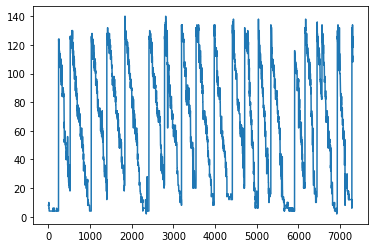

In [6]:
container = df.loc[df["container_id"] == "1"]
old_height = np.array(container["height_in_cm"].tolist()).astype("float32")
real_height = np.array(container["real_height"].tolist()).astype("float32")

plt.plot(old_height)


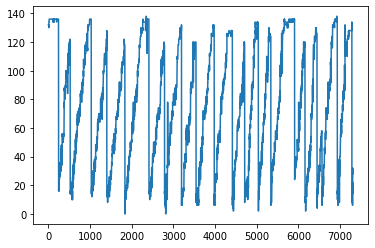

In [7]:
plt.plot(real_height)

# Smooth height

In [8]:
df["smoothed_heigth"] = "0.0"

In [9]:
df_counter = 0

for p in range(len(df["container_id"].unique().tolist())):
    container = df.loc[df["container_id"] == str(77-p)]
    heigth_list = np.array(container["real_height"].tolist()).astype("float32")
    new_height_list = uniform_filter1d(heigth_list, size=10)
    
    for x in range(len(new_height_list)):
        df["smoothed_heigth"][df_counter] = new_height_list[x]
        df_counter = df_counter + 1

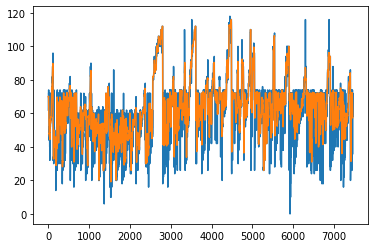

In [10]:
container = df.loc[df["container_id"] == "40"]
height = np.array(container["real_height"].tolist()).astype("float32")
smoothed_height = np.array(container["smoothed_heigth"].tolist()).astype("float32")

plt.plot(height)
plt.plot(smoothed_height)

# Calc and adapt deltas

In [11]:
def calc_delta(values):
    new_delta = []
    for x in range(len(values)-1):
        value = values[x+1] - values[x]
        new_delta.append(value)
    
    #need one additional delta
    #calc it from past 2 deltas
    mocked = (new_delta[len(new_delta) - 1] + new_delta[len(new_delta) - 2]) / 2
    new_delta.append(mocked)
    
    return np.array(new_delta).astype("float32")

def cut_negatives(deltas, history):
    for x in range(len(deltas)):
        if deltas[x] < 0:
            counter = 0
            total = 0
            for y in range(1, history + 1):
                if x - y >= 0:
                    total = total + deltas[x-y]
                    counter = counter + 1
            if counter == 0:
                deltas[x] = 0
            else:
                deltas[x] = total / counter

    return np.array(deltas).astype("float32")

# calc + cut
def adapt_delta(values):
    return cut_negatives(calc_delta(values), 3)



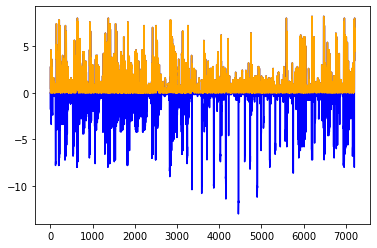

In [12]:
container = df.loc[df["container_id"] == "77"]
height = np.array(container["smoothed_heigth"].tolist()).astype("float32")

plt.plot(calc_delta(height), "blue")
plt.plot(adapt_delta(height), "orange")

In [13]:
df["smoothed_delta"] = "0.0"

In [14]:
df_counter = 0

for p in range(len(df["container_id"].unique().tolist())):
    container = df.loc[df["container_id"] == str(77-p)]
    heigth_list = np.array(container["smoothed_heigth"].tolist()).astype("float32")
    delta_list = adapt_delta(heigth_list)
    
    for x in range(len(delta_list)):
        df["smoothed_delta"][df_counter] = delta_list[x]
        df_counter = df_counter + 1

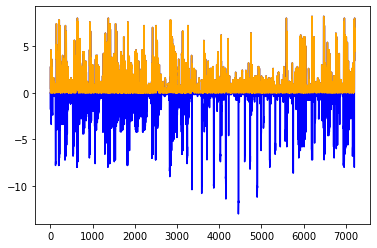

In [15]:
container = df.loc[df["container_id"] == "77"]
height = np.array(container["smoothed_heigth"].tolist()).astype("float32")
deltas = np.array(container["smoothed_delta"].tolist()).astype("float32")

plt.plot(calc_delta(height), "blue")
plt.plot(deltas, "orange")

In [16]:
df.keys()

Index(['container_id', 'height_in_cm', 'temperatur_in_grad',
       'niederschlag_in_mm', 'ist_industriegebiet', 'ist_wohngebiet',
       'ist_feiertag', 'datum', 'sekunde', 'minute',
       ...
       'DEVEUI_70B3D50070001780', 'DEVEUI_70B3D50070001781',
       'DEVEUI_70B3D50070001782', 'DEVEUI_70B3D50070001786',
       'DEVEUI_70B3D50070001787', 'DEVEUI_70B3D50070001788',
       'DEVEUI_70B3D50070001789', 'real_height', 'smoothed_heigth',
       'smoothed_delta'],
      dtype='object', length=104)

In [17]:
max(np.array(df["smoothed_delta"]).astype("float32"))

12.599999

In [18]:
df.to_csv(os.path.join(srcDir, "smoothed_data.csv"), index=False)

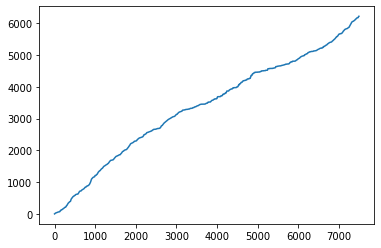

In [19]:
xx = df.loc[df["container_id"] == "50"]
xx = xx["smoothed_delta"].tolist()

result = 0
plt.plot(np.cumsum(xx))